# Challenge DataTour 2024 : Prévision de la production d’énergie solaire en Afrique

## I. Set-up

### Installation & import des packages

In [ ]:
%%capture
!pip install sklego optuna catboost xgboost lightgbm

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, StackingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklego.linear_model import LADRegression
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

# set random seed for reproducibily
np.random.seed(2024)

### Importation des données

In [ ]:
# files path
train_path       = "https://raw.githubusercontent.com/dataafriquehub/energy_data/refs/heads/main/train.csv"
test_path        = "https://raw.githubusercontent.com/dataafriquehub/energy_data/refs/heads/main/test.csv"
submission_path  = "https://raw.githubusercontent.com/dataafriquehub/energy_data/refs/heads/main/submission.csv"

# function to import our dataset
def import_data(train_path, test_path, submission_path):
    train       =  pd.read_csv(train_path)
    test        =  pd.read_csv(test_path)
    submission  =  pd.read_csv(submission_path)
    return train, test, submission

train, test, submission = import_data(train_path, test_path, submission_path)
df_all = pd.concat([train, test], axis=0)

## II. Exploratory Data Analysis - EDA

In [ ]:
print("==="*25)
print(f"First few rows Training: \n {df_all.head(3)} \n\n")
print("==="*25)
print(f"First few rows Submission: \n {submission.head(3)} \n\n")
print("==="*25)
print(f"Shape of the data: \n\tTraining {df_all.shape}  \n\tSubmission {submission.shape} \n\n")
print("==="*25)

'print("==="*25)\nprint(f"First few rows Training: \n {df_all.head(3)} \n\n")\nprint("==="*25)\nprint(f"First few rows Submission: \n {submission.head(3)} \n\n")\nprint("==="*25)\nprint(f"Shape of the data: \n\tTraining {df_all.shape}  \n\tSubmission {submission.shape} \n\n")\nprint("==="*25)'

In [ ]:
print("==="*25)
print(f"Number of duplicated values: \n\tTraining {df_all.duplicated().sum()}  \n\tSubmission {df_all.duplicated().sum()} \n\n")
print("==="*25)
print(f"Number of missing values by cols: \nTraining {df_all.isna().sum().sort_values(ascending=False)}  \nSubmission {submission.isna().sum().sort_values(ascending=False)} \n\n")
print("==="*25)

'print("==="*25)\nprint(f"Number of duplicated values: \n\tTraining {df_all.duplicated().sum()}  \n\tSubmission {df_all.duplicated().sum()} \n\n")\nprint("==="*25)\nprint(f"Number of missing values by cols: \nTraining {df_all.isna().sum().sort_values(ascending=False)}  \nSubmission {submission.isna().sum().sort_values(ascending=False)} \n\n")\nprint("==="*25)'

In [ ]:
df_all.groupby('country')[['demande_energetique_actuelle', 'demande_energetique_projectee']].mean()

,demande_energetique_actuelle,demande_energetique_projectee
country,,
Algeria,2553.716602,3885.245303
Angola,2541.573676,3865.348804
Benin,2567.710708,3914.652430
Botswana,2520.373142,3859.846984
Burkina Faso,2538.336239,3854.898451
Burundi,2568.705566,3906.450521
Cameroon,2539.305683,3870.731111
Cape Verde,2566.355139,3905.335028
Central African Republic,2562.272026,3894.051626


In [ ]:
df_all.groupby("country")["population"].mean().sort_values()

,population
country,
Seychelles,98347.0
Sao Tome and Principe,219159.0
Cape Verde,555987.0
Comoros,869601.0
Djibouti,988000.0
Eswatini (Swaziland),1160164.0
Equatorial Guinea,1402985.0
Guinea-Bissau,1968001.0
Lesotho,2142249.0


In [ ]:
diff_demande_energetique = train['demande_energetique_projectee'] - train['demande_energetique_actuelle']
print(f""" Quelle Différence entre demande_energetique_projectee et demande_energetique_actuelle?
\n\tMoyenne de la diff: {diff_demande_energetique.mean()}, \n\tEcart type de la diff: {diff_demande_energetique.std()}""")

 Quelle Différence entre demande_energetique_projectee et demande_energetique_actuelle?

	Moyenne de la diff: 1341.2051519931033, 
	Ecart type de la diff: 1093.2217385125257


### Analyse univariée

In [ ]:
# fonction to calculate univariate stats like pandas describe method
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]
    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

"# fonction to calculate univariate stats like pandas describe method\ndef univariate_stats(df):\n    #df.drop('id', axis=1, inplace=True)\n    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])\n    for col in df:\n        if is_numeric_dtype(df[col]):\n            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]\n        else:\n            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]\n    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)\n\npd.set

In [ ]:
# Call the function on train
univariate_stats(df_all)

In [ ]:
# Call the function to check univariate stats on submission dataset
univariate_stats(submission)

In [ ]:
# List of numerical columns and categorical columns
target       = 'demande_energetique_projectee'
categ_cols   = df_all.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_all.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove(target)

print(f"Colonnes numériques {numeric_cols}")
print(f"Colonnes numériques {categ_cols}")

Colonnes numériques ['lat', 'lon', 'population', 'taux_ensoleillement', 'demande_energetique_actuelle', 'capacite_installee_actuelle', 'duree_ensoleillement_annuel', 'cout_installation_solaire', 'proximite_infrastructures_energetiques', 'taux_adoption_energies_renouvelables', 'stabilite_politique', 'taux_acces_energie', 'niveau_urbanisation', 'potentiel_investissement', 'emissions_co2_evitees', 'idh', 'nombre_animaux_domestiques']
Colonnes numériques ['country', 'types_sols', 'habit_de_mariage']


In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.kdeplot(ax=ax, data=train, x=target, fill=True, color='steelblue').set_title('demande_energetique_projectee distribution in Train')
plt.show()

"fig, ax = plt.subplots(figsize=(6, 6))\n\nsns.kdeplot(ax=ax, data=train, x=target, fill=True, color='steelblue').set_title('demande_energetique_projectee distribution in Train')\nplt.show()"

In [ ]:
def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        #print(var_name)
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')      # plot train data

        if var_name != target_col:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Submission')    # plot test data
        ax.set_title(f'{var_name} Distribution')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(df_all[numeric_cols], submission[numeric_cols], target, n_cols=5)

"def plot_histograms(df_train, df_test, target_col, n_cols=3):\n    n_rows = (len(df_train.columns) - 1) // n_cols + 1\n    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))\n    axes = axes.flatten()\n\n    for i, var_name in enumerate(df_train.columns.tolist()):\n        #print(var_name)\n        ax = axes[i]\n        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')      # plot train data\n\n        if var_name != target_col:\n            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Submission')    # plot test data\n        ax.set_title(f'{var_name} Distribution')\n        ax.legend()\n\n    plt.tight_layout()\n    plt.show()\n\nplot_histograms(df_all[numeric_cols], submission[numeric_cols], target, n_cols=5)"

In [ ]:
def plot_boxplot(df, title='', drop_cols=[target], n_cols=3):
    sns.set_style('darkgrid')
    cols = df.columns #.drop(drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    # reset index to avoid duplicate index issues
    df = df.reset_index(drop=True)

    for i, var_name in enumerate(cols):
        #print(var_name)
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]
        sns.boxplot(data=df, y=var_name, ax=ax, showmeans=True,
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name}')

    fig.suptitle(f'{title} boxplot', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_boxplot(df_all[numeric_cols], title='Train', n_cols=6)
plot_boxplot(submission[numeric_cols], title='Submission', n_cols=6)

'def plot_boxplot(df, title=\'\', drop_cols=[target], n_cols=3):\n    sns.set_style(\'darkgrid\')\n    cols = df.columns #.drop(drop_cols)\n    n_rows = (len(cols) - 1) // n_cols + 1\n    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))\n\n    # reset index to avoid duplicate index issues\n    df = df.reset_index(drop=True)\n\n    for i, var_name in enumerate(cols):\n        #print(var_name)\n        row, col = i // n_cols, i % n_cols\n        ax = axes[row, col]\n        sns.boxplot(data=df, y=var_name, ax=ax, showmeans=True,\n                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})\n        ax.set_title(f\'{var_name}\')\n\n    fig.suptitle(f\'{title} boxplot\', fontweight=\'bold\', fontsize=16)\n    plt.tight_layout()\n    plt.show()\n\nplot_boxplot(df_all[numeric_cols], title=\'Train\', n_cols=6)\nplot_boxplot(submission[numeric_cols], title=\'Submission\', n_cols=6)'

In [ ]:
categorical_cols_to_display = df_all.select_dtypes(include=['object', 'int64']).columns.tolist()
for col in categorical_cols_to_display:
    print(f"Number of values in the {col} column is:\n{df_all[col].value_counts() }")
    print("==" * 30)

'categorical_cols_to_display = df_all.select_dtypes(include=[\'object\', \'int64\']).columns.tolist()\nfor col in categorical_cols_to_display:\n    print(f"Number of values in the {col} column is:\n{df_all[col].value_counts() }")\n    print("==" * 30)'

In [ ]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=df_all, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

'_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))\n\nfor index, col in enumerate(categorical_cols_to_display):\n    r = index // 2\n    c = index % 2\n    g = sns.countplot(data=df_all, x=col , ax=ax[r][c], width=0.6)\n    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)\n    ax[r][c].set_title(f\'{col} distribution\', fontsize=24)\n    plt.tight_layout()'

### Analyse Bivariée

In [ ]:
# this just an intermediate function that will be used in bivstats for one-way ANOVA
def anova(df, feature, label):
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])

    return stats.f_oneway(*group_labels)


# function to calculate bivariate stats; Pearson' correlation, p-value and one-way ANOVA
def bivstats(df, label):
    # Create an empty DataFrame to store output
    output_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value'])

    for col in df:
        if col != label:
            if df[col].isnull().sum() == 0:
                if is_numeric_dtype(df[col]):   # Only calculate r,
                    r, p = stats.pearsonr(df[label], df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r, 3)), round(p,6)]
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F, 3), round(p,6)]
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, np.nan]

    return output_df.sort_values(by=['Effect size', 'Stat'], ascending=[False, False])

pd.options.display.float_format = '{:.5f}'.format
bivstats(df_all, target)

"# this just an intermediate function that will be used in bivstats for one-way ANOVA\ndef anova(df, feature, label):\n    groups = df[feature].unique()\n    df_grouped = df.groupby(feature)\n    group_labels = []\n    for g in groups:\n        g_list = df_grouped.get_group(g)\n        group_labels.append(g_list[label])\n\n    return stats.f_oneway(*group_labels)\n\n\n# function to calculate bivariate stats; Pearson' correlation, p-value and one-way ANOVA\ndef bivstats(df, label):\n    # Create an empty DataFrame to store output\n    output_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value'])\n\n    for col in df:\n        if col != label:\n            if df[col].isnull().sum() == 0:\n                if is_numeric_dtype(df[col]):   # Only calculate r,\n                    r, p = stats.pearsonr(df[label], df[col])\n                    output_df.loc[col] = ['r', np.sign(r), abs(round(r, 3)), round(p,6)]\n                else:\n                    F, p = anova(df[[col, lab

In [ ]:
corr_mat_df_all = df_all[numeric_cols + [target]].corr()
corr_mat_submission = submission[numeric_cols].corr()

df_all_mask = np.triu(np.ones_like(corr_mat_df_all, dtype = bool))
submission_mask = np.triu(np.ones_like(corr_mat_submission, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

fig, axes = plt.subplots(1, 2, figsize = (25, 10))
sns.heatmap(corr_mat_df_all, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, ax = axes[0], mask = df_all_mask).set_title('Correlations Among Features (Training Dataset)')
sns.heatmap(corr_mat_submission, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, ax = axes[1], mask = submission_mask).set_title('Correlations Among Features (Submission Dataset)');

"corr_mat_df_all = df_all[numeric_cols + [target]].corr()\ncorr_mat_submission = submission[numeric_cols].corr()\n\ndf_all_mask = np.triu(np.ones_like(corr_mat_df_all, dtype = bool))\nsubmission_mask = np.triu(np.ones_like(corr_mat_submission, dtype = bool))\n\ncmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)\n\nfig, axes = plt.subplots(1, 2, figsize = (25, 10))\nsns.heatmap(corr_mat_df_all, annot = True, cmap = cmap, fmt = '.2f', center = 0,\n            annot_kws = {'size': 12}, ax = axes[0], mask = df_all_mask).set_title('Correlations Among Features (Training Dataset)')\nsns.heatmap(corr_mat_submission, annot = True, cmap = cmap, fmt = '.2f', center = 0,\n            annot_kws = {'size': 12}, ax = axes[1], mask = submission_mask).set_title('Correlations Among Features (Submission Dataset)');"

In [ ]:
# Plotting function
def plot_scatter_with_fixed_col(df, fixed_col, hue=False, drop_cols=[], size=5, title=''):
    sns.set_style('darkgrid')
    if hue:
        cols = df.columns.drop([hue, fixed_col] + drop_cols, errors='ignore')
    else:
        cols = df.columns.drop([fixed_col] + drop_cols, errors='ignore')

    n_cols = 4
    n_rows = (len(cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size, size/n_cols*n_rows), sharex=False, sharey=False)
    fig.suptitle(f'training data scatter plot vs. target', fontsize=15, fontweight='bold', y=1)

    # reset index to avoid duplicate index issues
    df = df.reset_index(drop=True)

    for i, col in enumerate(cols):
        n_row = i // n_cols
        n_col = i % n_cols
        ax = axes[n_row, n_col]
        ax.set_xlabel(f'{col}', fontsize=6)
        ax.set_ylabel(f'{fixed_col}', fontsize=6)

        # Plot the scatterplot
        if hue:
            sns.scatterplot(data=df, x=col, y=fixed_col, hue=hue, ax=ax,
                            s=40, edgecolor='gray', alpha=0.3, palette='bright')
            ax.legend(title=hue, title_fontsize=12, fontsize=12)
        else:
            sns.scatterplot(data=df, x=col, y=fixed_col, ax=ax,
                            #s=2, edgecolor='gray', alpha=0.1
                            )

        ax.tick_params(axis='both', which='major', labelsize=2)
        ax.set_title(f'{col}', fontsize=8)

    plt.tight_layout()
    plt.show()

# Call the function
plot_scatter_with_fixed_col(df_all, fixed_col=target, size=16, title='Train+Test data')

"# Plotting function\ndef plot_scatter_with_fixed_col(df, fixed_col, hue=False, drop_cols=[], size=5, title=''):\n    sns.set_style('darkgrid')\n    if hue:\n        cols = df.columns.drop([hue, fixed_col] + drop_cols, errors='ignore')\n    else:\n        cols = df.columns.drop([fixed_col] + drop_cols, errors='ignore')\n\n    n_cols = 4\n    n_rows = (len(cols) - 1) // n_cols + 1\n    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size, size/n_cols*n_rows), sharex=False, sharey=False)\n    fig.suptitle(f'training data scatter plot vs. target', fontsize=15, fontweight='bold', y=1)\n\n    # reset index to avoid duplicate index issues\n    df = df.reset_index(drop=True)\n\n    for i, col in enumerate(cols):\n        n_row = i // n_cols\n        n_col = i % n_cols\n        ax = axes[n_row, n_col]\n        ax.set_xlabel(f'{col}', fontsize=6)\n        ax.set_ylabel(f'{fixed_col}', fontsize=6)\n\n        # Plot the scatterplot\n        if hue:\n            sns.scatterplot(data=df, x=col, y

In [ ]:
sns.scatterplot(data=df_all, x="demande_energetique_actuelle", y="demande_energetique_projectee")

In [ ]:
temp_data = df_all.copy()

const = 0
temp_data["log_demande_energetique_actuelle"] = np.log(temp_data["demande_energetique_actuelle"]) + const
sns.scatterplot(data=temp_data, x="log_demande_energetique_actuelle", y="demande_energetique_projectee");

'temp_data = df_all.copy()\n\nconst = 0\ntemp_data["log_demande_energetique_actuelle"] = np.log(temp_data["demande_energetique_actuelle"]) + const\nsns.scatterplot(data=temp_data, x="log_demande_energetique_actuelle", y="demande_energetique_projectee");'

INTERESTING!!!

## III. Feature Engineering

Quelques idées:
- Label encode the country column ranking them by `demande_energetique_actuelle`
- Try PCA

In [ ]:
columns_to_drop = ['country']
df_all     = df_all.drop(columns=columns_to_drop, axis=1)
submission = submission.drop(columns=columns_to_drop, axis=1)

df_all.shape, submission.shape

((212500, 20), (25000, 19))

### Encoding

In [ ]:
# label encoding de la variable country en fonction de la colonne demande_energetique_actuelle

# colonne d'index pour conserver l'ordre initial
#df_all = X.reset_index(drop=False).rename(columns={'index': 'original_index'})

#X = X.sort_values(by='demande_energetique_actuelle', ascending=False)
#label_encoder = LabelEncoder()

In [ ]:
# label encode country column
#df_all['country'] = label_encoder.fit_transform(df_all['country'])

df_all_prep = df_all.copy()

# one hot encode other categorical variables
df_all_prep = pd.get_dummies(df_all_prep, columns=['types_sols', 'habit_de_mariage'], drop_first=True)

print(f"""shapes:
\n\t initial: {df_all.shape},
\n\t transformed: {df_all_prep.shape}\n""")
print("===="*15)

df_all_prep.head(3)

shapes:

	 initial: (212500, 20),

	 transformed: (212500, 21)



,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,...,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,emissions_co2_evitees,idh,nombre_animaux_domestiques,types_sols_rocheux,types_sols_sablonneux,habit_de_mariage_traditionnel
0,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,15.450396,...,2.575677,67.501053,35.733884,4,555.209808,0.441787,2,True,False,True
1,-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,1.461833,...,2.747196,61.851008,40.134654,2,3722.310275,0.380139,5,False,True,True
2,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,17.135819,...,3.091990,17.384882,46.964564,5,9824.421047,0.678362,0,False,False,False


In [ ]:
# label encode country column
#submission['country'] = label_encoder.transform(submission['country'])
submission_prep = submission.copy()

# one hot encode other categorical variables
submission_prep = pd.get_dummies(submission_prep, columns=['types_sols', 'habit_de_mariage'], drop_first=True)

print(f"""shapes:
\n\t initial: {submission.shape},
\n\t transformed: {submission_prep.shape}\n""")
print("===="*15)
submission_prep.head(3)

shapes:

	 initial: (25000, 19),

	 transformed: (25000, 20)



,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,taux_adoption_energies_renouvelables,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,emissions_co2_evitees,idh,nombre_animaux_domestiques,types_sols_rocheux,types_sols_sablonneux,habit_de_mariage_traditionnel
0,8.4606,-11.7799,7976983,6.016310,2288.205830,1506.365949,3856.453895,1453.281847,56.433841,25.196118,9.187338,35.022992,58.938006,2,9432.861305,0.722109,3,False,True,True
1,8.4606,-11.7799,7976983,6.410925,2402.680846,1878.297944,3652.332264,1076.560589,46.100498,27.037202,5.307233,52.154399,58.293952,4,7466.567405,0.518997,3,False,False,True
2,6.8769,31.3069,11193725,4.642565,3996.471566,344.400305,3810.507756,980.596863,88.583926,47.880078,1.462924,79.302572,24.914731,2,1239.535797,0.785365,9,False,True,False


In [ ]:
# Print the mapping between original categories (countries) and their new labels
#country_label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
#print("Country to Label Mapping:\n", country_label_mapping)

### Missing values treatment

In [ ]:
"""# imputer class
imputer = KNNImputer(n_neighbors=5)

X_prep = pd.DataFrame(imputer.fit_transform(X_prep), columns = X_prep.columns)
X_prep.head(3)

submission_prep = pd.DataFrame(imputer.transform(submission_prep), columns = submission_prep.columns)
submission_prep.head(3)"""

'# imputer class\nimputer = KNNImputer(n_neighbors=5)\n\nX_prep = pd.DataFrame(imputer.fit_transform(X_prep), columns = X_prep.columns)\nX_prep.head(3)\n\nsubmission_prep = pd.DataFrame(imputer.transform(submission_prep), columns = submission_prep.columns)\nsubmission_prep.head(3)'

In [ ]:
df_all_prep['taux_adoption_energies_renouvelables'] = df_all_prep.taux_adoption_energies_renouvelables.fillna(df_all_prep.taux_adoption_energies_renouvelables.mean())
submission_prep['taux_adoption_energies_renouvelables'] = submission_prep.taux_adoption_energies_renouvelables.fillna(submission_prep.taux_adoption_energies_renouvelables.mean())

In [ ]:
print(f"Total Number of missing values: \nTraining: {df_all_prep.isna().sum().sum()}  \nSubmission: {submission_prep.isna().sum().sum()} \n\n")
print("==="*25)

Total Number of missing values: 
Training: 0  
Submission: 0 




### Detect outliers

In [ ]:
"""# function to detect outliers using the IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # calculate the limits
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    # return outliers
    outliers = df[(df[feature] > upper_limit) | (df[feature] < lower_limit)]
    return outliers, upper_limit, lower_limit

# Example usage:
outliers, upper, lower = detect_outliers(X_prep, "population")
print("Upper limit:", upper)
print("Lower limit:", lower)
print("Outliers:\n", outliers)"""

'# function to detect outliers using the IQR method\ndef detect_outliers(df, feature):\n    Q1 = df[feature].quantile(0.25)\n    Q3 = df[feature].quantile(0.75)\n    IQR = Q3 - Q1\n\n    # calculate the limits\n    upper_limit = Q3 + 1.5 * IQR\n    lower_limit = Q1 - 1.5 * IQR\n\n    # return outliers\n    outliers = df[(df[feature] > upper_limit) | (df[feature] < lower_limit)]\n    return outliers, upper_limit, lower_limit\n\n# Example usage:\noutliers, upper, lower = detect_outliers(X_prep, "population")\nprint("Upper limit:", upper)\nprint("Lower limit:", lower)\nprint("Outliers:\n", outliers)'

In [ ]:
"""_, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 6))
sns.boxplot(x=df_all_prep['population'], ax=ax)
"""
# removing outliers using the above function
#df_all = df_all[(df_all['population'] > lower) & (df_all['population'] < upper)] #train
#submission = submission[(submission['population'] > lower) & (submission['population'] < upper)]     #submission

#sns.boxplot(x=train['population'], ax=ax[1])
#plt.title('population distribution before VS after removing outliers')
#plt.show()

"_, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 6))\nsns.boxplot(x=df_all_prep['population'], ax=ax)\n"

### Engineering

In [ ]:
# Function to add new features to the dataset
def feature_engineering(df):
    # Adding brand new features
    """df['solar_efficiency'] = df['demande_energetique_actuelle'] / df['capacite_installee_actuelle']
    df['energy_cost_ratio'] = df['demande_energetique_actuelle'] / df['cout_installation_solaire']
    df['energy_adoption_interaction'] = df['demande_energetique_actuelle'] * df['taux_adoption_energies_renouvelables']
    df['infra_access_interaction'] = df['proximite_infrastructures_energetiques'] * df['taux_acces_energie']
    df['annual_solar_energy_potential'] = df['duree_ensoleillement_annuel'] * df['capacite_installee_actuelle']
    df['total_emissions_reduced'] = df['emissions_co2_evitees'] * df['taux_adoption_energies_renouvelables']
    df["log_demande_energetique_actuelle"] = np.log(df["demande_energetique_actuelle"])

    # Collecting names of the new columns
    new_cols = [
        'solar_efficiency',
        'energy_cost_ratio',
        'energy_adoption_interaction',
        'infra_access_interaction',
        'annual_solar_energy_potential',
        'total_emissions_reduced'
    ]"""

    return df #, new_cols

In [ ]:
df_all_prep = feature_engineering(df_all_prep)
submission_prep = feature_engineering(submission_prep)

df_all_prep.head(3)

,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,...,stabilite_politique,taux_acces_energie,niveau_urbanisation,potentiel_investissement,emissions_co2_evitees,idh,nombre_animaux_domestiques,types_sols_rocheux,types_sols_sablonneux,habit_de_mariage_traditionnel
0,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,15.450396,...,2.575677,67.501053,35.733884,4,555.209808,0.441787,2,True,False,True
1,-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,1.461833,...,2.747196,61.851008,40.134654,2,3722.310275,0.380139,5,False,True,True
2,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,17.135819,...,3.091990,17.384882,46.964564,5,9824.421047,0.678362,0,False,False,False


### Dimentionality reduction

In [ ]:
cols_for_pca = list(df_all_prep.columns)
cols_for_pca.remove('demande_energetique_projectee')
print(cols_for_pca)

['lat', 'lon', 'population', 'taux_ensoleillement', 'demande_energetique_actuelle', 'capacite_installee_actuelle', 'duree_ensoleillement_annuel', 'cout_installation_solaire', 'proximite_infrastructures_energetiques', 'taux_adoption_energies_renouvelables', 'stabilite_politique', 'taux_acces_energie', 'niveau_urbanisation', 'potentiel_investissement', 'emissions_co2_evitees', 'idh', 'nombre_animaux_domestiques', 'types_sols_rocheux', 'types_sols_sablonneux', 'habit_de_mariage_traditionnel']


In [ ]:
"""pca = PCA()
pca.fit(df_all_prep[cols_for_pca])

# explained variance for each component
explained_variance = pca.explained_variance_ratio_
# cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()"""

"pca = PCA()\npca.fit(df_all_prep[cols_for_pca])\n\n# explained variance for each component\nexplained_variance = pca.explained_variance_ratio_\n# cumulative explained variance\ncumulative_variance = np.cumsum(explained_variance)\n\n# Plot the cumulative explained variance\nplt.figure(figsize=(6, 6))\nplt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')\nplt.xlabel('Number of Components')\nplt.ylabel('Cumulative Explained Variance')\nplt.title('Explained Variance by Number of Principal Components')\nplt.grid(True)\nplt.show()"

In [ ]:
"""# finding the number of components to reach, say, 99% of the variance
n_components = np.argmax(cumulative_variance >= 0.99) + 1
print(f'Number of components to explain 99% variance: {n_components}')"""

"# finding the number of components to reach, say, 99% of the variance\nn_components = np.argmax(cumulative_variance >= 0.99) + 1\nprint(f'Number of components to explain 99% variance: {n_components}')"

In [ ]:
# function for PCA features but I'll keep this as a last resort

def add_pca_features(X_train, X_test):
    # Select the columns for PCA
    pca_features = cols_for_pca
    n_components = 5 # len(pca_features)

    # Create the pipeline
    pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))

    # Perform PCA
    pipeline.fit(X_train[pca_features])

    # Create column names for PCA feature%%s
    pca_columns = [f'PCA_{i}' for i in range(n_components)]

    # Add PCA features to the dataframe
    X_train[pca_columns] = pipeline.transform(X_train[pca_features])
    X_test[pca_columns] = pipeline.transform(X_test[pca_features])

    return X_train, X_test


df_all_pca, submission_pca = add_pca_features(df_all_prep, submission_prep)
df_all_pca.shape, submission_pca.shape
df_all_pca.head(3)

,lat,lon,population,taux_ensoleillement,demande_energetique_actuelle,demande_energetique_projectee,capacite_installee_actuelle,duree_ensoleillement_annuel,cout_installation_solaire,proximite_infrastructures_energetiques,...,idh,nombre_animaux_domestiques,types_sols_rocheux,types_sols_sablonneux,habit_de_mariage_traditionnel,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4
0,-19.0154,29.1549,14862924,5.004870,485.085906,544.232257,583.128945,3936.978948,926.985577,15.450396,...,0.441787,2,True,False,True,-1.586654,1.373723,-0.540225,1.103137,-0.527500
1,-0.2280,15.8277,5518092,4.609972,1422.802172,1864.048290,163.908475,3753.749894,862.739803,1.461833,...,0.380139,5,False,True,True,1.492601,0.143802,-0.740391,0.413349,0.361332
2,-22.9576,18.4904,2540905,5.792826,4711.082367,5525.433108,1404.435659,3804.854034,1298.932535,17.135819,...,0.678362,0,False,False,False,-0.050556,1.218872,-0.836402,1.521155,-1.115942


### Scaling/Normalization

In [ ]:
"""#scaling the data
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X))
test_eng = pd.DataFrame(scaler.transform(test_eng))
test_eng"""

'#scaling the data\nscaler = StandardScaler()\n\nX = pd.DataFrame(scaler.fit_transform(X))\ntest_eng = pd.DataFrame(scaler.transform(test_eng))\ntest_eng'

### Splitting validation data

In [ ]:
X_all = df_all_prep.drop(columns=[target], axis=1)
Y_all = df_all_prep[target]
test_eng = submission_prep #.drop(columns=columns_to_drop, axis=1)

X_all.shape, Y_all.shape, submission.shape

((212500, 25), (212500,), (25000, 19))

In [ ]:
"""X_all = df_all_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]
Y_all = df_all_pca[target]
test_eng = submission_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]

X_all.shape, Y_all.shape, test_eng.shape"""

"X_all = df_all_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]\nY_all = df_all_pca[target]\ntest_eng = submission_pca[['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]\n\nX_all.shape, Y_all.shape, test_eng.shape"

In [ ]:
X, X_val, Y, Y_val = train_test_split(X_all, Y_all, test_size=0.1, random_state=42)
X.shape, Y.shape, test_eng.shape

((191250, 25), (191250,), (25000, 25))

## IV. Modélisation

In [ ]:
#lasso_best_params = {'alpha': 0.9464268988662359, 'max_iter': 791, 'tol': 0.00047308177979131136, 'fit_intercept': False, 'positive': True, 'selection': 'cyclic'}
#lgb_best_params   = {'verbose': -1, 'num_leaves': 102, 'max_depth': 1, 'learning_rate': 0.034723637811449146, 'n_estimators': 878, 'min_child_samples': 51, 'min_child_weight': 0.012788573193490927, 'subsample': 0.8968760260635513, 'subsample_freq': 3, 'colsample_bytree': 0.8659594112847362, 'reg_alpha': 0.0018755405264117115, 'reg_lambda': 0.0020152388749633348}
#hist_best_params  = {'max_iter': 746, 'max_depth': 3, 'learning_rate': 0.011843975951032079, 'min_samples_leaf': 46, 'l2_regularization': 0.007300763896598253, 'max_leaf_nodes': 80, 'max_bins': 182, 'early_stopping': True, 'validation_fraction': 0.35392508436658743}
#xgb_best_params   = {'learning_rate': 0.006816640645251852, 'max_depth': 3, 'n_estimators': 1172}
#cat_best_params   = {'depth': 8, 'learning_rate': 0.0044579525750365395, 'iterations': 1680}

In [ ]:
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds   = list(), list()
xgb_cv_scores, xgb_preds   = list(), list()
cat_cv_scores, cat_preds   = list(), list()
lr_cv_scores, lr_preds = list(), list()
gb_cv_scores, gb_preds = list(), list()
lasso_cv_scores, lasso_preds = list(), list()

lad_cv_scores, lad_preds = list(), list()
lr_ens_cv_scores, lr_ens_preds = list(), list()

imp_hist = pd.DataFrame()
imp_xgb = pd.DataFrame()
imp_ens = pd.DataFrame()
imp = pd.DataFrame()

skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    print('=====================================================================')

    #==================================================== Linear regression ====================================================#
    lr_md = LinearRegression().fit(X_train, Y_train)
    # Validation
    lr_pred_1 = lr_md.predict(X_test)
    lr_score_fold = root_mean_squared_error(Y_test, lr_pred_1)
    lr_cv_scores.append(lr_score_fold)

    # Prediction
    lr_pred_2 = lr_md.predict(test_eng)
    lr_preds.append(lr_pred_2)
    print('Fold N°', i, '==> LR -       RMSE: ====>', lr_score_fold)

    #==================================================== Lasso Regression ====================================================#
    lasso_md = Lasso(alpha=1.0, max_iter=1000, random_state=42).fit(X_train, Y_train)
    # Validation
    lasso_pred_1 = lasso_md.predict(X_test)
    lasso_score_fold = root_mean_squared_error(Y_test, lasso_pred_1)
    lasso_cv_scores.append(lasso_score_fold)
    # Prediction
    lasso_pred_2 = lasso_md.predict(test_eng)
    lasso_preds.append(lasso_pred_2)
    print('Fold N°', i, '==> Lasso -       RMSE: ====>', lasso_score_fold)

    #==================================================== LightGBM ==========================================================#
    lgb_params = {  "objective": "rmse", # ="mae"
                    "metric": "rmse",
                    #"learning_rate": 0.01, # 0.01
                    #"n_estimators": 5000,
                    #"max_depth": 10,
                    #"num_leaves": 255,
                    #"reg_alpha": 0.1,
                    #"reg_lambda": 0.1,
                    #"subsample": 0.4,
                    "verbose": -1,
                    }

    lgb_md = LGBMRegressor(**lgb_params).fit(X_train, Y_train)

    # Validation
    lgb_pred_1 = lgb_md.predict(X_test)
    lgb_score_fold = root_mean_squared_error(Y_test, lgb_pred_1)
    lgb_cv_scores.append(lgb_score_fold)

    # Prediction
    lgb_pred_2 = lgb_md.predict(test_eng)
    lgb_preds.append(lgb_pred_2)

    # Importance
    _imp = pd.DataFrame({"features": X.columns, "importance": lgb_md.feature_importances_})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)
    print('Fold N°', i, '==> LightGBM -          RMSE: ====>', lgb_score_fold)

    #==================================================== HistGradientBoosting ====================================================#
    hist_md = HistGradientBoostingRegressor(loss = 'squared_error',
                                            #l2_regularization = 0.01,
                                            #early_stopping = False,
                                            #learning_rate = 0.01,
                                            #max_iter = 1000,
                                            #max_depth = 10,
                                            #max_bins = 255,
                                            #min_samples_leaf = 30,
                                            #max_leaf_nodes = 30
                                            ).fit(X_train, Y_train)
    # Validation
    hist_pred_1 = hist_md.predict(X_test)
    hist_score_fold = root_mean_squared_error(Y_test, hist_pred_1)
    hist_cv_scores.append(hist_score_fold)

    # Prediction
    hist_pred_2 = hist_md.predict(test_eng)
    hist_preds.append(hist_pred_2)
    print('Fold N°', i, '==> HistGradient -       RMSE: ====>', hist_score_fold)

    #======================================================== XGBoost ============================================================#
    xgb_md = XGBRegressor(objective = 'reg:squarederror',
                          #tree_method = 'hist',
                          #colsample_bytree = 0.9,
                          #gamma = 0.65,
                          #learning_rate = 0.01,
                          #max_depth = 7,
                          #min_child_weight = 20,
                          #n_estimators = 5000,
                          #subsample = 0.7,
                          random_state = 42).fit(X_train, Y_train,
                                                #eval_set = [(X_train, Y_train), (X_test, Y_test)],
                                                verbose=0
                                                )
    # Validation
    xgb_pred_1 = xgb_md.predict(X_test)
    xgb_score_fold = root_mean_squared_error(Y_test, xgb_pred_1)
    xgb_cv_scores.append(xgb_score_fold)

    # Prediction
    xgb_pred_2 = xgb_md.predict(test_eng)
    xgb_preds.append(xgb_pred_2)
    print('Fold N°', i, '==> XGBoost -        RMSE: ====>', xgb_score_fold)

    #========================================================= CatBoost ========================================================#
    cat_md = CatBoostRegressor(loss_function = 'RMSE',
                               verbose = False,
                               random_state = 42,
                               grow_policy = 'Lossguide',
                               task_type = 'CPU',
                               #iterations = 1000,
                               #learning_rate = 0.03,
                               #depth = 10,
                               #random_strength = 0.2,
                               #bagging_temperature = 0.7,
                               #border_count = 254,
                               #l2_leaf_reg = 0.001,
                               ).fit(X_train, Y_train)

    # Validation
    cat_pred_1 = cat_md.predict(X_test)
    cat_score_fold = root_mean_squared_error(Y_test, cat_pred_1)
    cat_cv_scores.append(cat_score_fold)

    # Prediction
    cat_pred_2 = cat_md.predict(test_eng)
    cat_preds.append(cat_pred_2)
    print('Fold N°', i, '==> CatBoost       - RMSE: ====>', cat_score_fold)

    #==================================================== GradientBoostingRegressor ====================================================#
    gb_md = GradientBoostingRegressor().fit(X_train, Y_train)
    # Validation
    gb_pred_1 = gb_md.predict(X_test)
    gb_score_fold = root_mean_squared_error(Y_test, gb_pred_1)
    gb_cv_scores.append(gb_score_fold)

    # Prediction
    gb_pred_2 = gb_md.predict(test_eng)
    gb_preds.append(gb_pred_2)
    print('Fold N°', i, '==> GradientBoostingRegressor -       RMSE: ====>', gb_score_fold)

    #========================================================= LAD 1 Ensemble =========================================================#
    x = pd.DataFrame({
        'hist': np.round(hist_pred_1.tolist()),
        'lgb': np.round(lgb_pred_1.tolist()),
        'xgb': np.round(xgb_pred_1.tolist()),
        'cat': np.round(cat_pred_1.tolist()),
        'lr': np.round(lr_pred_1.tolist()),
        'gb': np.round(gb_pred_1.tolist()),
        'lasso': np.round(lasso_pred_1.tolist()),
    })
    y = Y_test

    x_test = pd.DataFrame({
        'hist': np.round(hist_pred_2.tolist()),
        'lgb': np.round(lgb_pred_2.tolist()),
        'xgb': np.round(xgb_pred_2.tolist()),
        'cat': np.round(cat_pred_2.tolist()),
        'lr': np.round(lr_pred_2.tolist()),
        'gb': np.round(gb_pred_2.tolist()),
        'lasso': np.round(lasso_pred_2.tolist()),
    })

    lad_md = LADRegression(fit_intercept=True, positive=False).fit(x, y)

    # Validation
    lad_pred = lad_md.predict(x)
    lad_score = root_mean_squared_error(y, lad_pred)
    lad_cv_scores.append(lad_score)

    # Predictions
    lad_pred_test = lad_md.predict(x_test)
    lad_preds.append(lad_pred_test)
    print('Fold N°', i, '==> LAD Model ensemble - RMSE: ====>', lad_score)

    #========================================================= LinearRegression Ensemble =========================================================#
    lr_ens_md = LinearRegression().fit(x, y)

    # Validation
    lr_ens_pred = lr_ens_md.predict(x)
    lr_ens_score = root_mean_squared_error(y, lr_ens_pred)
    lr_ens_cv_scores.append(lr_ens_score)

    # Predictions
    lr_ens_pred_test = lr_ens_md.predict(x_test)
    lr_ens_preds.append(lr_ens_pred_test)
    print('Fold N°', i, '==> Linear Regression Ensemble - RMSE: ====>', lr_ens_score)

Fold N° 0 ==> LR -       RMSE: ====> 793.1689721750415
Fold N° 0 ==> Lasso -       RMSE: ====> 793.1597801905772
Fold N° 0 ==> LightGBM -          RMSE: ====> 794.7468808297608
Fold N° 0 ==> HistGradient -       RMSE: ====> 794.7341175840547
Fold N° 0 ==> XGBoost -        RMSE: ====> 806.7123393236645
Fold N° 0 ==> CatBoost       - RMSE: ====> 798.7241345096444
Fold N° 0 ==> GradientBoostingRegressor -       RMSE: ====> 793.6276155755683
Fold N° 0 ==> LAD Model ensemble - RMSE: ====> 793.2716651574318
Fold N° 0 ==> Linear Regression Ensemble - RMSE: ====> 793.1154236507297
Fold N° 1 ==> LR -       RMSE: ====> 797.455388408745
Fold N° 1 ==> Lasso -       RMSE: ====> 797.4467920340895
Fold N° 1 ==> LightGBM -          RMSE: ====> 798.7988635979938
Fold N° 1 ==> HistGradient -       RMSE: ====> 798.2123345102736
Fold N° 1 ==> XGBoost -        RMSE: ====> 810.847259965822
Fold N° 1 ==> CatBoost       - RMSE: ====> 802.6319708856604
Fold N° 1 ==> GradientBoostingRegressor -       RMSE: ====

In [ ]:
# Display important features for LGBMRegressor
imp = imp.groupby("features")["importance"].agg(["mean", "std"])
imp.columns = ["importance", "importance_std"]
imp["importance_cov"] = imp["importance_std"] / imp["importance"]
imp = imp.reset_index(drop=False)
display(imp.sort_values("importance", ascending=False, ignore_index=True))

,features,importance,importance_std,importance_cov
0,demande_energetique_actuelle,863.6,17.657859,0.020447
1,taux_adoption_energies_renouvelables,134.0,15.411035,0.115008
2,cout_installation_solaire,130.4,8.961027,0.068720
3,niveau_urbanisation,130.2,8.526429,0.065487
4,taux_acces_energie,129.0,6.442049,0.049938
5,idh,126.4,10.163661,0.080409
6,PCA_4,126.0,11.489125,0.091184
7,duree_ensoleillement_annuel,124.4,9.343447,0.075108
8,emissions_co2_evitees,121.4,8.905055,0.073353
9,stabilite_politique,116.4,8.677557,0.074549


In [ ]:
imp_xgb_md = pd.DataFrame({"features": X.columns, "importance": xgb_md.feature_importances_})

# Display important features for XGB
imp_xgb_md = imp_xgb_md.groupby("features")["importance"].agg(["mean", "std"])
imp_xgb_md.columns = ["importance", "importance_std"]
imp_xgb_md["importance_cov"] = imp_xgb_md["importance_std"] / imp_xgb_md["importance"]
imp_xgb_md = imp_xgb_md.reset_index(drop=False)
display(imp_xgb_md.sort_values("importance", ascending=False, ignore_index=True))

,features,importance,importance_std,importance_cov
0,demande_energetique_actuelle,0.894847,NaN,NaN
1,PCA_0,0.005274,NaN,NaN
2,stabilite_politique,0.005073,NaN,NaN
3,nombre_animaux_domestiques,0.005053,NaN,NaN
4,taux_adoption_energies_renouvelables,0.004952,NaN,NaN
5,niveau_urbanisation,0.004888,NaN,NaN
6,emissions_co2_evitees,0.004873,NaN,NaN
7,PCA_2,0.004863,NaN,NaN
8,PCA_1,0.004852,NaN,NaN
9,cout_installation_solaire,0.004761,NaN,NaN


In [ ]:
# Linear regression scores
lr_cv_score = np.mean(lr_cv_scores)
print(f"Score on CV test data             ======> {lr_cv_score}")

lr_preds_val = lr_md.predict(X_val)
lr_preds_val_score = root_mean_squared_error(Y_val, lr_preds_val)
print(f"Score on Valid data (unseen data) ======> {lr_preds_val_score}")

Score on CV test data             ======> 798.9144668288485
Score on Valid data (unseen data) ======> 800.1332855376303


In [ ]:
# Lasso scores
lasso_cv_score = np.mean(lasso_cv_scores)
print(f"Score on CV test data             ======> {lasso_cv_score}")

lasso_preds_val = lasso_md.predict(X_val)
lasso_preds_val_score = root_mean_squared_error(Y_val, lasso_preds_val)
print(f"Score on Valid data (unseen data) ======> {lasso_preds_val_score}")

Score on CV test data             ======> 798.9042743763328
Score on Valid data (unseen data) ======> 800.1332888716263


In [ ]:
# Gradient Boosting scores
gb_cv_score = np.mean(gb_cv_scores)
print(f"Score on CV test data             ======> {gb_cv_score}")

gb_preds_val = gb_md.predict(X_val)
gb_preds_val_score = root_mean_squared_error(Y_val, gb_preds_val)
print(f"Score on Valid data (unseen data) ======> {gb_preds_val_score}")

Score on CV test data             ======> 799.5228446165253
Score on Valid data (unseen data) ======> 800.0978238202842


In [ ]:
# Ligth GBM scores
lgb_cv_score = np.mean(lgb_cv_scores)
print(f"Score on CV test data             ======> {lgb_cv_score}")

lgb_preds_val = lgb_md.predict(X_val)
lgb_preds_val_score = root_mean_squared_error(Y_val, lgb_preds_val)
print(f"Score on Valid data (unseen data) ======> {lgb_preds_val_score}")

Score on CV test data             ======> 800.560244178552
Score on Valid data (unseen data) ======> 801.3789948752573


In [ ]:
# HistGB scores
hist_cv_score = np.mean(hist_cv_scores)
print(f"Score on CV test data             ======> {hist_cv_score}")

hist_preds_val = hist_md.predict(X_val)
hist_preds_val_score = root_mean_squared_error(Y_val, hist_preds_val)
print(f"Score on Valid data (unseen data) ======> {hist_preds_val_score}")

Score on CV test data             ======> 800.1006430495426
Score on Valid data (unseen data) ======> 802.0344377711895


In [ ]:
# XGBoost scores
xgb_cv_score = np.mean(xgb_cv_scores)
print(f"Score on CV test data             ======> {xgb_cv_score}")

xgb_preds_val = xgb_md.predict(X_val)
xgb_preds_val_score = root_mean_squared_error(Y_val, xgb_preds_val)
print(f"Score on Valid data (unseen data) ======> {xgb_preds_val_score}")

Score on CV test data             ======> 812.249259608802
Score on Valid data (unseen data) ======> 814.0017467971239


In [ ]:
# CatBoost scores
cat_cv_score = np.mean(cat_cv_scores)
print(f"Score on CV test data             ======> {cat_cv_score}")

cat_preds_val = cat_md.predict(X_val)
cat_preds_val_score = root_mean_squared_error(Y_val, cat_preds_val)
print(f"Score on Valid data (unseen data) ======> {cat_preds_val_score}")

Score on CV test data             ======> 804.3681272402065
Score on Valid data (unseen data) ======> 807.5028635465948


In [ ]:
# Créer les prédictions d'ensemble sur le set de validation pour chaque méta-modèle

# Validation data
x_val = pd.DataFrame({
    'hist': np.round(hist_preds_val.tolist()),
    'lgb': np.round(lgb_preds_val.tolist()),
    'xgb': np.round(xgb_preds_val.tolist()),
    'cat': np.round(cat_preds_val.tolist()),
    'lr': np.round(lr_preds_val.tolist()),
    'gb': np.round(gb_preds_val.tolist()),
    'lasso': np.round(lasso_preds_val.tolist()),
})

#========================================================= LAD Regression Ensemble =========================================================#

# Calcul du score moyen sur les données de cross-validation pour LAD
lad_cv_score = np.mean(lad_cv_scores)
print(f"LAD - Score on CV test data             ======> {lad_cv_score}")

# Évaluation LAD sur le jeu de validation
lad_preds_val = lad_md.predict(x_val)
lad_preds_val_score = root_mean_squared_error(Y_val, lad_preds_val)
print(f"LAD - Score on Valid data (unseen data) ======> {lad_preds_val_score}")

#========================================================= Linear Regression Ensemble =========================================================#
# Calcul du score moyen sur les données de cross-validation pour Linear Regression
lr_ens_cv_score = np.mean(lr_ens_cv_scores)
print(f"Linear Regression Ensemble - Score on CV test data ======> {lr_ens_cv_score}")

# Évaluation Linear Regression sur le jeu de validation
lr_ens_preds_val = lr_ens_md.predict(x_val)
lr_ens_preds_val_score = root_mean_squared_error(Y_val, lr_ens_preds_val)
print(f"Linear Regression Ensemble - Score on Valid data (unseen data) ======> {lr_ens_preds_val_score}")

LAD - Score on CV test data             ======> 798.920069605274
LAD - Score on Valid data (unseen data) ======> 800.3989075736108
Linear Regression Ensemble - Score on CV test data ======> 798.8272711772582
Linear Regression Ensemble - Score on Valid data (unseen data) ======> 800.2206553742199


**After Tuning:**


- **Linear regression scores:**  
Score on CV test data             ======> 798.9144668288485  
Score on Valid data (unseen data) ======> 800.1332855376303  

- **Lasso scores**  
Score on CV test data             ======> 798.9043259257681  
Score on Valid data (unseen data) ======> 800.1334426784532  

- **Gradient Boosting scores**  
Score on CV test data             ======> 799.5266503283077  
Score on Valid data (unseen data) ======> 800.1275653284664

- **Ligth GBM scores**  
Score on CV test data             ======> 799.2721719231226  
Score on Valid data (unseen data) ======> 800.2044259431666

- **HistGB scores**  
Score on CV test data             ======> 799.3449053748061  
Score on Valid data (unseen data) ======> 800.4738009586938

- **XGBoost scores**  
Score on CV test data             ======> 799.2986374770268  
Score on Valid data (unseen data) ======> 799.9783194224641

- **CatBoost scores**  
Score on CV test data             ======> 799.1398004625337  
Score on Valid data (unseen data) ======> 800.1159399293665

- **LAD ens scores**  
Score on CV test data             ======> 798.8834911398192  
Score on Valid data (unseen data) ======> 799.9976196393353


**feature eng**
-
LAD - Score on CV test data             ======> 798.8323670231811  
LAD - Score on Valid data (unseen data) ======> 800.0491036404799  
-
Linear Regression Ensemble - Score on CV test data ======> 798.7838164936836  
Linear Regression Ensemble - Score on Valid data (unseen data) ======> 799.9597970050114

## V. Soumission et Post processing

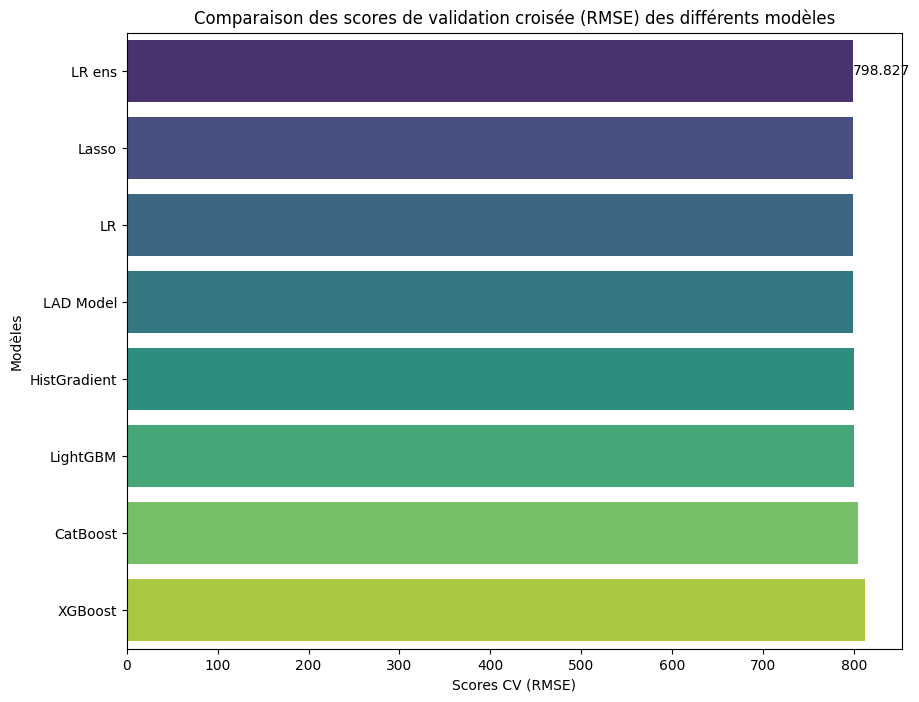

In [ ]:
# Calculer la moyenne des scores de validation croisée pour chaque modèle
lr_cv_score = np.mean(lr_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
cat_cv_score = np.mean(cat_cv_scores)
lasso_cv_score = np.mean(lasso_cv_scores)
lad_cv_score = np.mean(lad_cv_scores)
lr_ens_cv_score = np.mean(lr_ens_cv_scores)

# Créer le DataFrame avec tous les modèles et leurs scores moyens
model_perf = pd.DataFrame({
    'Models': ['LR', 'HistGradient', 'LightGBM', 'XGBoost', 'CatBoost', 'LAD Model', 'Lasso', 'LR ens'],
    'CV-scores': [lr_cv_score, hist_cv_score, lgb_cv_score, xgb_cv_score, cat_cv_score, lad_cv_score, lasso_cv_score, lr_ens_cv_score]
})

model_perf = model_perf.sort_values(by="CV-scores")

# Visualiser les performances des modèles
plt.figure(figsize=(10, 8))
ax = sns.barplot(y='Models', x='CV-scores', data=model_perf, palette="viridis")
ax.bar_label(ax.containers[0])
plt.title('Comparaison des scores de validation croisée (RMSE) des différents modèles')
plt.xlabel('Scores CV (RMSE)')
plt.ylabel('Modèles')
plt.show()

In [ ]:
submission[target] = pd.DataFrame(lad_preds).apply(np.mean, axis = 0)
submission['id'] = list(range(1, len(submission) + 1))
submission[['id','demande_energetique_projectee']].to_csv('New_LAD_Ensemble_Baseline_submission.csv', index = False)
print("Predictions saved to 'New_LAD_Ensemble_Baseline_submission.csv")

Predictions saved to 'New_LAD_Ensemble_Baseline_submission.csv


In [ ]:
submission[target] = pd.DataFrame(lr_ens_preds).apply(np.mean, axis = 0)
submission['id'] = list(range(1, len(submission) + 1))
submission[['id','demande_energetique_projectee']].to_csv('New_LR_Baseline_submission.csv', index = False)
print("Predictions saved to 'New_LR_Baseline_submission.csv")

Predictions saved to 'New_LR_Baseline_submission.csv


In [ ]:
# Store weights for each model (these should ideally be tuned or based on validation performance)
weights = {'hist': 1.0, 'lgb': 1.0, 'xgb': 1.0, 'cat': 1.0, 'lr': 1.0, 'gb': 1.0, 'lasso': 1.0 }

# Create a dataframe for storing all test predictions
test_preds_df = pd.DataFrame({
    'hist': np.mean(hist_preds, axis=0),
    'lgb': np.mean(lgb_preds, axis=0),
    'xgb': np.mean(xgb_preds, axis=0),
    'cat': np.mean(cat_preds, axis=0),
    'lr': np.mean(lr_preds, axis=0),
    'gb': np.mean(gb_preds, axis=0),
    'lasso': np.mean(lasso_preds, axis=0)
})

# Weighted averaging
test_preds_df['weighted_avg'] = (
    test_preds_df['hist'] * weights['hist'] +
    test_preds_df['lgb'] * weights['lgb'] +
    test_preds_df['xgb'] * weights['xgb'] +
    test_preds_df['cat'] * weights['cat'] +
    test_preds_df['lr'] * weights['lr'] +
    test_preds_df['gb'] * weights['gb'] +
    test_preds_df['lasso'] * weights['lasso']
) / sum(weights.values())

# Final predictions for submission
final_predictions = test_preds_df['weighted_avg']

# Create the submission file
submission = pd.DataFrame({
    'id': list(range(1, len(final_predictions) + 1)),
    'demande_energetique_projectee': final_predictions
})
submission.to_csv('Weighted_Avg_submission.csv', index=False)
print("Predictions saved to 'Weighted_Avg_submission.csv'")

Predictions saved to 'Weighted_Avg_submission.csv'


## VI. Hyperparameters Tuning

In [ ]:
"""import optuna
from optuna.samplers import TPESampler

# Cross-validation setup
skf = KFold(n_splits = 5, random_state = 42, shuffle = True)"""

'import optuna\nfrom optuna.samplers import TPESampler\n\n# Cross-validation setup\nskf = KFold(n_splits = 5, random_state = 42, shuffle = True)'

In [ ]:
"""# Define Optuna objective functions for each model
def optimize_lr(trial, X, Y):
    # No hyperparameters to optimize for Linear Regression
    return 0  # Placeholder

def optimize_lasso(trial, X, Y):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
    max_iter = trial.suggest_int('max_iter', 500, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        lasso_md = Lasso(alpha=alpha, max_iter=max_iter, random_state=42)
        lasso_md.fit(X_train, Y_train)
        lasso_pred = lasso_md.predict(X_test)
        score = root_mean_squared_error(Y_test, lasso_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_gb(trial, X, Y):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        gb_md = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
        gb_md.fit(X_train, Y_train)
        gb_pred = gb_md.predict(X_test)
        score = root_mean_squared_error(Y_test, gb_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_lgb(trial, X, Y):
    num_leaves = trial.suggest_int('num_leaves', 10, 300)
    max_depth = trial.suggest_int('max_depth', -1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        lgb_md = LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, verbose=-1)
        lgb_md.fit(X_train, Y_train)
        lgb_pred = lgb_md.predict(X_test)
        score = root_mean_squared_error(Y_test, lgb_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_hist(trial, X, Y):
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        hist_md = HistGradientBoostingRegressor(max_iter=max_iter, max_depth=max_depth, learning_rate=learning_rate)
        hist_md.fit(X_train, Y_train)
        hist_pred = hist_md.predict(X_test)
        score = root_mean_squared_error(Y_test, hist_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_xgb(trial, X, Y):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        xgb_md = XGBRegressor(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=42)
        xgb_md.fit(X_train, Y_train)
        xgb_pred = xgb_md.predict(X_test)
        score = root_mean_squared_error(Y_test, xgb_pred)
        scores.append(score)

    return np.mean(scores)


def optimize_cat(trial, X, Y):
    depth = trial.suggest_int('depth', 4, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    iterations = trial.suggest_int('iterations', 100, 2000)

    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        cat_md = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, verbose=0)
        cat_md.fit(X_train, Y_train)
        cat_pred = cat_md.predict(X_test)
        score = root_mean_squared_error(Y_test, cat_pred)
        scores.append(score)

    return np.mean(scores)"""

"# Define Optuna objective functions for each model\ndef optimize_lr(trial, X, Y):\n    # No hyperparameters to optimize for Linear Regression\n    return 0  # Placeholder\n\ndef optimize_lasso(trial, X, Y):\n    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)\n    max_iter = trial.suggest_int('max_iter', 500, 2000)\n\n    scores = []\n    for train_ix, test_ix in skf.split(X, Y):\n        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]\n        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]\n\n        lasso_md = Lasso(alpha=alpha, max_iter=max_iter, random_state=42)\n        lasso_md.fit(X_train, Y_train)\n        lasso_pred = lasso_md.predict(X_test)\n        score = root_mean_squared_error(Y_test, lasso_pred)\n        scores.append(score)\n\n    return np.mean(scores)\n\n\ndef optimize_gb(trial, X, Y):\n    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1.0)\n    n_estimators = trial.suggest_int('n_estimators', 100, 2000)\n    max_depth = trial.suggest

In [ ]:
"""# Define each Optuna study and optimize each model
studies = {}
for model_name, objective in zip(['xgb', 'cat', 'gb'],
                                 [optimize_xgb, optimize_cat, optimize_gb]):
    study = optuna.create_study(direction='minimize', sampler=TPESampler())
    study.optimize(lambda trial: objective(trial, X, Y), n_trials=50)
    studies[model_name] = study
    print(f"Best trial for {model_name} found with parameters: {study.best_params} and score: {study.best_value}")"""

'# Define each Optuna study and optimize each model\nstudies = {}\nfor model_name, objective in zip([\'xgb\', \'cat\', \'gb\'],\n                                 [optimize_xgb, optimize_cat, optimize_gb]):\n    study = optuna.create_study(direction=\'minimize\', sampler=TPESampler())\n    study.optimize(lambda trial: objective(trial, X, Y), n_trials=50)\n    studies[model_name] = study\n    print(f"Best trial for {model_name} found with parameters: {study.best_params} and score: {study.best_value}")'

In [ ]:
"""# Print out the results
for model_name, study in studies.items():
    print(f"\nModel: {model_name}")
    print("Best Score:", study.best_value)
    print("Best Parameters:", study.best_params)"""

'# Print out the results\nfor model_name, study in studies.items():\n    print(f"\nModel: {model_name}")\n    print("Best Score:", study.best_value)\n    print("Best Parameters:", study.best_params)'